# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.discrete, source=Source.all, past=Past.last_bin, durl=Durl.all, max_distance=1)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 26478 substitutions for model Model(time=Time.discrete, source=Source.all, past=Past.last_bin, durl=Durl.all, max_distance=1)


  0% (    1 of 26478) |             | Elapsed Time: 0:00:03 ETA:  1 day, 3:50:47

  0% (   82 of 26478) |                    | Elapsed Time: 0:00:04 ETA:  0:05:23

  0% (  165 of 26478) |                    | Elapsed Time: 0:00:05 ETA:  0:05:19

  0% (  247 of 26478) |                    | Elapsed Time: 0:00:06 ETA:  0:05:18

  1% (  331 of 26478) |                    | Elapsed Time: 0:00:07 ETA:  0:05:16

  1% (  413 of 26478) |                    | Elapsed Time: 0:00:08 ETA:  0:05:15

  1% (  501 of 26478) |                    | Elapsed Time: 0:00:09 ETA:  0:05:10

  2% (  588 of 26478) |                    | Elapsed Time: 0:00:10 ETA:  0:05:07

  2% (  662 of 26478) |                    | Elapsed Time: 0:00:11 ETA:  0:05:05

  2% (  750 of 26478) |                    | Elapsed Time: 0:00:12 ETA:  0:05:01

  3% (  839 of 26478) |                    | Elapsed Time: 0:00:13 ETA:  0:04:57

  3% (  923 of 26478) |                    | Elapsed Time: 0:00:14 ETA:  0:04:55

  3% (  993 of 26478) |                    | Elapsed Time: 0:00:15 ETA:  0:04:50

  4% ( 1085 of 26478) |                    | Elapsed Time: 0:00:16 ETA:  0:04:47

  4% ( 1181 of 26478) |                    | Elapsed Time: 0:00:17 ETA:  0:04:40

  4% ( 1266 of 26478) |                    | Elapsed Time: 0:00:18 ETA:  0:04:40

  5% ( 1324 of 26478) |#                   | Elapsed Time: 0:00:19 ETA:  0:04:41

  5% ( 1406 of 26478) |#                   | Elapsed Time: 0:00:20 ETA:  0:04:42

  5% ( 1488 of 26478) |#                   | Elapsed Time: 0:00:21 ETA:  0:04:43

  5% ( 1546 of 26478) |#                   | Elapsed Time: 0:00:22 ETA:  0:04:56

  6% ( 1616 of 26478) |#                   | Elapsed Time: 0:00:23 ETA:  0:05:01

  6% ( 1655 of 26478) |#                   | Elapsed Time: 0:00:23 ETA:  0:05:11

  6% ( 1720 of 26478) |#                   | Elapsed Time: 0:00:24 ETA:  0:05:25

  6% ( 1798 of 26478) |#                   | Elapsed Time: 0:00:25 ETA:  0:05:34

  7% ( 1876 of 26478) |#                   | Elapsed Time: 0:00:26 ETA:  0:05:38

  7% ( 1956 of 26478) |#                   | Elapsed Time: 0:00:27 ETA:  0:05:36

  7% ( 1986 of 26478) |#                   | Elapsed Time: 0:00:28 ETA:  0:05:40

  7% ( 2063 of 26478) |#                   | Elapsed Time: 0:00:29 ETA:  0:05:42

  8% ( 2139 of 26478) |#                   | Elapsed Time: 0:00:30 ETA:  0:05:29

  8% ( 2217 of 26478) |#                   | Elapsed Time: 0:00:31 ETA:  0:05:24

  8% ( 2297 of 26478) |#                   | Elapsed Time: 0:00:32 ETA:  0:05:15

  8% ( 2317 of 26478) |#                   | Elapsed Time: 0:00:32 ETA:  0:05:09

  8% ( 2378 of 26478) |#                   | Elapsed Time: 0:00:33 ETA:  0:05:18

  9% ( 2440 of 26478) |#                   | Elapsed Time: 0:00:34 ETA:  0:05:26

  9% ( 2504 of 26478) |#                   | Elapsed Time: 0:00:35 ETA:  0:05:36

  9% ( 2579 of 26478) |#                   | Elapsed Time: 0:00:36 ETA:  0:05:34

 10% ( 2648 of 26478) |##                  | Elapsed Time: 0:00:37 ETA:  0:05:31

 10% ( 2730 of 26478) |##                  | Elapsed Time: 0:00:38 ETA:  0:05:26

 10% ( 2805 of 26478) |##                  | Elapsed Time: 0:00:39 ETA:  0:05:27

 10% ( 2888 of 26478) |##                  | Elapsed Time: 0:00:40 ETA:  0:05:24

 11% ( 2979 of 26478) |##                  | Elapsed Time: 0:00:41 ETA:  0:05:08

 11% ( 3062 of 26478) |##                  | Elapsed Time: 0:00:42 ETA:  0:04:55

 11% ( 3145 of 26478) |##                  | Elapsed Time: 0:00:43 ETA:  0:04:44

 12% ( 3231 of 26478) |##                  | Elapsed Time: 0:00:44 ETA:  0:04:37

 12% ( 3310 of 26478) |##                  | Elapsed Time: 0:00:45 ETA:  0:04:36

 12% ( 3394 of 26478) |##                  | Elapsed Time: 0:00:46 ETA:  0:04:34

 13% ( 3463 of 26478) |##                  | Elapsed Time: 0:00:47 ETA:  0:04:43

 13% ( 3545 of 26478) |##                  | Elapsed Time: 0:00:48 ETA:  0:04:42

 13% ( 3641 of 26478) |##                  | Elapsed Time: 0:00:49 ETA:  0:04:42

 14% ( 3724 of 26478) |##                  | Elapsed Time: 0:00:50 ETA:  0:04:41

 14% ( 3809 of 26478) |##                  | Elapsed Time: 0:00:51 ETA:  0:04:39

 14% ( 3893 of 26478) |##                  | Elapsed Time: 0:00:52 ETA:  0:04:39

 15% ( 3972 of 26478) |###                 | Elapsed Time: 0:00:53 ETA:  0:04:38

 15% ( 4055 of 26478) |###                 | Elapsed Time: 0:00:54 ETA:  0:04:38

 15% ( 4138 of 26478) |###                 | Elapsed Time: 0:00:55 ETA:  0:04:23

 15% ( 4223 of 26478) |###                 | Elapsed Time: 0:00:56 ETA:  0:04:21

 16% ( 4303 of 26478) |###                 | Elapsed Time: 0:00:57 ETA:  0:04:19

 16% ( 4388 of 26478) |###                 | Elapsed Time: 0:00:58 ETA:  0:04:18

 16% ( 4472 of 26478) |###                 | Elapsed Time: 0:00:59 ETA:  0:04:17

 17% ( 4562 of 26478) |###                 | Elapsed Time: 0:01:00 ETA:  0:04:13

 17% ( 4634 of 26478) |###                 | Elapsed Time: 0:01:01 ETA:  0:04:10

 17% ( 4720 of 26478) |###                 | Elapsed Time: 0:01:02 ETA:  0:04:08

 18% ( 4805 of 26478) |###                 | Elapsed Time: 0:01:03 ETA:  0:04:07

 18% ( 4891 of 26478) |###                 | Elapsed Time: 0:01:04 ETA:  0:04:04

 18% ( 4965 of 26478) |###                 | Elapsed Time: 0:01:05 ETA:  0:04:03

 19% ( 5051 of 26478) |###                 | Elapsed Time: 0:01:06 ETA:  0:04:02

 19% ( 5135 of 26478) |###                 | Elapsed Time: 0:01:07 ETA:  0:04:01

 19% ( 5222 of 26478) |###                 | Elapsed Time: 0:01:08 ETA:  0:03:58

 20% ( 5296 of 26478) |####                | Elapsed Time: 0:01:09 ETA:  0:03:59

 20% ( 5384 of 26478) |####                | Elapsed Time: 0:01:10 ETA:  0:03:59

 20% ( 5469 of 26478) |####                | Elapsed Time: 0:01:11 ETA:  0:03:58

 20% ( 5555 of 26478) |####                | Elapsed Time: 0:01:12 ETA:  0:03:57

 21% ( 5627 of 26478) |####                | Elapsed Time: 0:01:13 ETA:  0:03:56

 21% ( 5712 of 26478) |####                | Elapsed Time: 0:01:14 ETA:  0:03:55

 21% ( 5799 of 26478) |####                | Elapsed Time: 0:01:15 ETA:  0:03:53

 22% ( 5886 of 26478) |####                | Elapsed Time: 0:01:16 ETA:  0:03:51

 22% ( 5958 of 26478) |####                | Elapsed Time: 0:01:17 ETA:  0:03:51

 22% ( 6044 of 26478) |####                | Elapsed Time: 0:01:18 ETA:  0:03:50

 23% ( 6129 of 26478) |####                | Elapsed Time: 0:01:19 ETA:  0:03:50

 23% ( 6216 of 26478) |####                | Elapsed Time: 0:01:20 ETA:  0:03:48

 23% ( 6289 of 26478) |####                | Elapsed Time: 0:01:20 ETA:  0:03:48

 24% ( 6376 of 26478) |####                | Elapsed Time: 0:01:21 ETA:  0:03:46

 24% ( 6462 of 26478) |####                | Elapsed Time: 0:01:22 ETA:  0:03:45

 24% ( 6511 of 26478) |####                | Elapsed Time: 0:01:23 ETA:  0:04:01

 24% ( 6597 of 26478) |####                | Elapsed Time: 0:01:24 ETA:  0:04:00

 25% ( 6620 of 26478) |#####               | Elapsed Time: 0:01:25 ETA:  0:04:01

 25% ( 6708 of 26478) |#####               | Elapsed Time: 0:01:26 ETA:  0:03:59

 25% ( 6793 of 26478) |#####               | Elapsed Time: 0:01:27 ETA:  0:03:58

 25% ( 6881 of 26478) |#####               | Elapsed Time: 0:01:28 ETA:  0:03:56

 26% ( 6951 of 26478) |#####               | Elapsed Time: 0:01:29 ETA:  0:03:55

 26% ( 7038 of 26478) |#####               | Elapsed Time: 0:01:30 ETA:  0:03:55

 26% ( 7128 of 26478) |#####               | Elapsed Time: 0:01:31 ETA:  0:03:52

 27% ( 7195 of 26478) |#####               | Elapsed Time: 0:01:32 ETA:  0:03:42

 27% ( 7260 of 26478) |#####               | Elapsed Time: 0:01:33 ETA:  0:03:51

 27% ( 7282 of 26478) |#####               | Elapsed Time: 0:01:33 ETA:  0:03:55

 27% ( 7345 of 26478) |#####               | Elapsed Time: 0:01:34 ETA:  0:04:07

 27% ( 7407 of 26478) |#####               | Elapsed Time: 0:01:35 ETA:  0:04:19

 28% ( 7469 of 26478) |#####               | Elapsed Time: 0:01:36 ETA:  0:04:33

 28% ( 7537 of 26478) |#####               | Elapsed Time: 0:01:37 ETA:  0:04:43

 28% ( 7613 of 26478) |#####               | Elapsed Time: 0:01:38 ETA:  0:05:08

 29% ( 7682 of 26478) |#####               | Elapsed Time: 0:01:39 ETA:  0:05:05

 29% ( 7754 of 26478) |#####               | Elapsed Time: 0:01:40 ETA:  0:04:59

 29% ( 7838 of 26478) |#####               | Elapsed Time: 0:01:41 ETA:  0:04:43

 29% ( 7921 of 26478) |#####               | Elapsed Time: 0:01:42 ETA:  0:04:29

 30% ( 7944 of 26478) |######              | Elapsed Time: 0:01:42 ETA:  0:04:20

 30% ( 8027 of 26478) |######              | Elapsed Time: 0:01:43 ETA:  0:04:06

 30% ( 8111 of 26478) |######              | Elapsed Time: 0:01:44 ETA:  0:03:55

 30% ( 8197 of 26478) |######              | Elapsed Time: 0:01:45 ETA:  0:03:46

 31% ( 8275 of 26478) |######              | Elapsed Time: 0:01:46 ETA:  0:03:43

 31% ( 8361 of 26478) |######              | Elapsed Time: 0:01:47 ETA:  0:03:34

 31% ( 8447 of 26478) |######              | Elapsed Time: 0:01:48 ETA:  0:03:26

 32% ( 8528 of 26478) |######              | Elapsed Time: 0:01:49 ETA:  0:03:26

 32% ( 8606 of 26478) |######              | Elapsed Time: 0:01:50 ETA:  0:03:28

 32% ( 8682 of 26478) |######              | Elapsed Time: 0:01:51 ETA:  0:03:31

 33% ( 8759 of 26478) |######              | Elapsed Time: 0:01:52 ETA:  0:03:33

 33% ( 8830 of 26478) |######              | Elapsed Time: 0:01:53 ETA:  0:03:41

 33% ( 8903 of 26478) |######              | Elapsed Time: 0:01:54 ETA:  0:03:46

 33% ( 8937 of 26478) |######              | Elapsed Time: 0:01:55 ETA:  0:03:51

 34% ( 9009 of 26478) |######              | Elapsed Time: 0:01:56 ETA:  0:03:59

 34% ( 9086 of 26478) |######              | Elapsed Time: 0:01:57 ETA:  0:04:00

 34% ( 9154 of 26478) |######              | Elapsed Time: 0:01:58 ETA:  0:04:05

 34% ( 9227 of 26478) |######              | Elapsed Time: 0:01:59 ETA:  0:04:04

 35% ( 9268 of 26478) |#######             | Elapsed Time: 0:01:59 ETA:  0:04:06

 35% ( 9343 of 26478) |#######             | Elapsed Time: 0:02:00 ETA:  0:04:06

 35% ( 9430 of 26478) |#######             | Elapsed Time: 0:02:01 ETA:  0:03:55

 35% ( 9511 of 26478) |#######             | Elapsed Time: 0:02:02 ETA:  0:03:49

 36% ( 9599 of 26478) |#######             | Elapsed Time: 0:02:03 ETA:  0:03:39

 36% ( 9638 of 26478) |#######             | Elapsed Time: 0:02:05 ETA:  0:04:01

 36% ( 9717 of 26478) |#######             | Elapsed Time: 0:02:06 ETA:  0:03:52

 37% ( 9799 of 26478) |#######             | Elapsed Time: 0:02:07 ETA:  0:03:45

 37% ( 9877 of 26478) |#######             | Elapsed Time: 0:02:08 ETA:  0:03:42

 37% ( 9930 of 26478) |#######             | Elapsed Time: 0:02:08 ETA:  0:03:41

 37% (10014 of 26478) |#######             | Elapsed Time: 0:02:09 ETA:  0:03:42

 38% (10092 of 26478) |#######             | Elapsed Time: 0:02:10 ETA:  0:03:42

 38% (10169 of 26478) |#######             | Elapsed Time: 0:02:11 ETA:  0:03:47

 38% (10247 of 26478) |#######             | Elapsed Time: 0:02:12 ETA:  0:03:44

 38% (10261 of 26478) |#######             | Elapsed Time: 0:02:12 ETA:  0:03:26

 39% (10351 of 26478) |#######             | Elapsed Time: 0:02:13 ETA:  0:03:19

 39% (10439 of 26478) |#######             | Elapsed Time: 0:02:14 ETA:  0:03:15

 39% (10529 of 26478) |#######             | Elapsed Time: 0:02:15 ETA:  0:03:08

 40% (10592 of 26478) |########            | Elapsed Time: 0:02:16 ETA:  0:03:02

 40% (10690 of 26478) |########            | Elapsed Time: 0:02:17 ETA:  0:02:54

 40% (10785 of 26478) |########            | Elapsed Time: 0:02:18 ETA:  0:02:46

 41% (10868 of 26478) |########            | Elapsed Time: 0:02:19 ETA:  0:02:41

 41% (10923 of 26478) |########            | Elapsed Time: 0:02:20 ETA:  0:02:50

 41% (10986 of 26478) |########            | Elapsed Time: 0:02:21 ETA:  0:03:03

 41% (11046 of 26478) |########            | Elapsed Time: 0:02:22 ETA:  0:03:17

 41% (11107 of 26478) |########            | Elapsed Time: 0:02:23 ETA:  0:03:33

 42% (11188 of 26478) |########            | Elapsed Time: 0:02:24 ETA:  0:03:35

 42% (11254 of 26478) |########            | Elapsed Time: 0:02:25 ETA:  0:03:45

 42% (11325 of 26478) |########            | Elapsed Time: 0:02:26 ETA:  0:04:00

 43% (11397 of 26478) |########            | Elapsed Time: 0:02:27 ETA:  0:04:07

 43% (11454 of 26478) |########            | Elapsed Time: 0:02:28 ETA:  0:04:03

 43% (11539 of 26478) |########            | Elapsed Time: 0:02:29 ETA:  0:03:50

 43% (11585 of 26478) |########            | Elapsed Time: 0:02:30 ETA:  0:03:42

 44% (11669 of 26478) |########            | Elapsed Time: 0:02:31 ETA:  0:03:26

 44% (11750 of 26478) |########            | Elapsed Time: 0:02:32 ETA:  0:03:14

 44% (11817 of 26478) |########            | Elapsed Time: 0:02:33 ETA:  0:03:21

 44% (11879 of 26478) |########            | Elapsed Time: 0:02:34 ETA:  0:03:31

 45% (11916 of 26478) |#########           | Elapsed Time: 0:02:34 ETA:  0:03:33

 45% (11998 of 26478) |#########           | Elapsed Time: 0:02:35 ETA:  0:03:25

 45% (12085 of 26478) |#########           | Elapsed Time: 0:02:36 ETA:  0:03:07

 45% (12167 of 26478) |#########           | Elapsed Time: 0:02:37 ETA:  0:03:07

 46% (12247 of 26478) |#########           | Elapsed Time: 0:02:38 ETA:  0:03:04

 46% (12327 of 26478) |#########           | Elapsed Time: 0:02:39 ETA:  0:03:05

 46% (12403 of 26478) |#########           | Elapsed Time: 0:02:40 ETA:  0:03:07

 47% (12487 of 26478) |#########           | Elapsed Time: 0:02:41 ETA:  0:02:57

 47% (12578 of 26478) |#########           | Elapsed Time: 0:02:42 ETA:  0:02:41

 47% (12650 of 26478) |#########           | Elapsed Time: 0:02:43 ETA:  0:02:46

 48% (12729 of 26478) |#########           | Elapsed Time: 0:02:44 ETA:  0:02:48

 48% (12801 of 26478) |#########           | Elapsed Time: 0:02:45 ETA:  0:02:53

 48% (12873 of 26478) |#########           | Elapsed Time: 0:02:46 ETA:  0:02:58

 48% (12909 of 26478) |#########           | Elapsed Time: 0:02:47 ETA:  0:03:01

 49% (12981 of 26478) |#########           | Elapsed Time: 0:02:48 ETA:  0:03:01

 49% (13067 of 26478) |#########           | Elapsed Time: 0:02:49 ETA:  0:02:59

 49% (13127 of 26478) |#########           | Elapsed Time: 0:02:50 ETA:  0:03:13

 49% (13195 of 26478) |#########           | Elapsed Time: 0:02:51 ETA:  0:03:15

 50% (13240 of 26478) |##########          | Elapsed Time: 0:02:52 ETA:  0:03:16

 50% (13315 of 26478) |##########          | Elapsed Time: 0:02:53 ETA:  0:03:43

 50% (13405 of 26478) |##########          | Elapsed Time: 0:02:54 ETA:  0:03:30

 51% (13505 of 26478) |##########          | Elapsed Time: 0:02:55 ETA:  0:03:11

 51% (13570 of 26478) |##########          | Elapsed Time: 0:02:56 ETA:  0:03:00

 51% (13651 of 26478) |##########          | Elapsed Time: 0:02:57 ETA:  0:02:54

 51% (13732 of 26478) |##########          | Elapsed Time: 0:02:58 ETA:  0:02:56

 52% (13819 of 26478) |##########          | Elapsed Time: 0:02:59 ETA:  0:02:41

 52% (13901 of 26478) |##########          | Elapsed Time: 0:03:00 ETA:  0:02:33

 52% (13968 of 26478) |##########          | Elapsed Time: 0:03:01 ETA:  0:02:13

 53% (14046 of 26478) |##########          | Elapsed Time: 0:03:02 ETA:  0:02:18

 53% (14129 of 26478) |##########          | Elapsed Time: 0:03:03 ETA:  0:02:26

 53% (14232 of 26478) |##########          | Elapsed Time: 0:03:04 ETA:  0:02:29

 54% (14312 of 26478) |##########          | Elapsed Time: 0:03:05 ETA:  0:02:29

 54% (14377 of 26478) |##########          | Elapsed Time: 0:03:06 ETA:  0:02:41

 54% (14449 of 26478) |##########          | Elapsed Time: 0:03:07 ETA:  0:02:43

 54% (14520 of 26478) |##########          | Elapsed Time: 0:03:08 ETA:  0:02:44

 55% (14563 of 26478) |###########         | Elapsed Time: 0:03:09 ETA:  0:02:39

 55% (14647 of 26478) |###########         | Elapsed Time: 0:03:10 ETA:  0:02:34

 55% (14732 of 26478) |###########         | Elapsed Time: 0:03:11 ETA:  0:02:32

 55% (14818 of 26478) |###########         | Elapsed Time: 0:03:12 ETA:  0:02:31

 56% (14894 of 26478) |###########         | Elapsed Time: 0:03:13 ETA:  0:02:28

 56% (14978 of 26478) |###########         | Elapsed Time: 0:03:14 ETA:  0:02:25

 56% (15068 of 26478) |###########         | Elapsed Time: 0:03:15 ETA:  0:02:11

 57% (15149 of 26478) |###########         | Elapsed Time: 0:03:16 ETA:  0:02:07

 57% (15198 of 26478) |###########         | Elapsed Time: 0:03:17 ETA:  0:02:16

 57% (15225 of 26478) |###########         | Elapsed Time: 0:03:17 ETA:  0:02:22

 57% (15309 of 26478) |###########         | Elapsed Time: 0:03:18 ETA:  0:02:21

 58% (15380 of 26478) |###########         | Elapsed Time: 0:03:19 ETA:  0:02:27

 58% (15429 of 26478) |###########         | Elapsed Time: 0:03:20 ETA:  0:02:47

 58% (15471 of 26478) |###########         | Elapsed Time: 0:03:21 ETA:  0:03:13

 58% (15536 of 26478) |###########         | Elapsed Time: 0:03:22 ETA:  0:03:26

 58% (15556 of 26478) |###########         | Elapsed Time: 0:03:23 ETA:  0:03:42

 58% (15614 of 26478) |###########         | Elapsed Time: 0:03:24 ETA:  0:04:02

 59% (15671 of 26478) |###########         | Elapsed Time: 0:03:25 ETA:  0:03:53

 59% (15748 of 26478) |###########         | Elapsed Time: 0:03:26 ETA:  0:03:34

 59% (15828 of 26478) |###########         | Elapsed Time: 0:03:27 ETA:  0:03:36

 60% (15887 of 26478) |############        | Elapsed Time: 0:03:27 ETA:  0:03:32

 60% (15966 of 26478) |############        | Elapsed Time: 0:03:28 ETA:  0:03:07

 60% (16046 of 26478) |############        | Elapsed Time: 0:03:29 ETA:  0:02:40

 60% (16118 of 26478) |############        | Elapsed Time: 0:03:30 ETA:  0:02:35

 61% (16198 of 26478) |############        | Elapsed Time: 0:03:31 ETA:  0:02:31

 61% (16218 of 26478) |############        | Elapsed Time: 0:03:32 ETA:  0:02:19

 61% (16312 of 26478) |############        | Elapsed Time: 0:03:33 ETA:  0:01:57

 61% (16399 of 26478) |############        | Elapsed Time: 0:03:34 ETA:  0:01:51

 62% (16484 of 26478) |############        | Elapsed Time: 0:03:35 ETA:  0:01:47

 62% (16549 of 26478) |############        | Elapsed Time: 0:03:35 ETA:  0:01:43

 62% (16640 of 26478) |############        | Elapsed Time: 0:03:36 ETA:  0:01:36

 63% (16713 of 26478) |############        | Elapsed Time: 0:03:37 ETA:  0:01:38

 63% (16807 of 26478) |############        | Elapsed Time: 0:03:38 ETA:  0:01:27

 63% (16880 of 26478) |############        | Elapsed Time: 0:03:39 ETA:  0:01:24

 64% (16967 of 26478) |############        | Elapsed Time: 0:03:40 ETA:  0:01:24

 64% (17030 of 26478) |############        | Elapsed Time: 0:03:41 ETA:  0:01:36

 64% (17120 of 26478) |############        | Elapsed Time: 0:03:42 ETA:  0:01:34

 64% (17195 of 26478) |############        | Elapsed Time: 0:03:43 ETA:  0:01:38

 65% (17211 of 26478) |#############       | Elapsed Time: 0:03:43 ETA:  0:01:41

 65% (17282 of 26478) |#############       | Elapsed Time: 0:03:45 ETA:  0:01:50

 65% (17339 of 26478) |#############       | Elapsed Time: 0:03:46 ETA:  0:01:58

 65% (17404 of 26478) |#############       | Elapsed Time: 0:03:47 ETA:  0:02:14

 66% (17490 of 26478) |#############       | Elapsed Time: 0:03:48 ETA:  0:02:10

 66% (17542 of 26478) |#############       | Elapsed Time: 0:03:48 ETA:  0:02:14

 66% (17629 of 26478) |#############       | Elapsed Time: 0:03:49 ETA:  0:01:58

 66% (17704 of 26478) |#############       | Elapsed Time: 0:03:50 ETA:  0:02:06

 67% (17782 of 26478) |#############       | Elapsed Time: 0:03:51 ETA:  0:02:03

 67% (17873 of 26478) |#############       | Elapsed Time: 0:03:52 ETA:  0:01:54

 67% (17960 of 26478) |#############       | Elapsed Time: 0:03:53 ETA:  0:01:36

 68% (18053 of 26478) |#############       | Elapsed Time: 0:03:54 ETA:  0:01:21

 68% (18099 of 26478) |#############       | Elapsed Time: 0:03:56 ETA:  0:02:00

 68% (18169 of 26478) |#############       | Elapsed Time: 0:03:57 ETA:  0:02:05

 68% (18204 of 26478) |#############       | Elapsed Time: 0:03:57 ETA:  0:02:10

 69% (18294 of 26478) |#############       | Elapsed Time: 0:03:58 ETA:  0:02:00

 69% (18370 of 26478) |#############       | Elapsed Time: 0:03:59 ETA:  0:02:00

 69% (18460 of 26478) |#############       | Elapsed Time: 0:04:00 ETA:  0:01:55

 70% (18535 of 26478) |##############      | Elapsed Time: 0:04:01 ETA:  0:01:47

 70% (18616 of 26478) |##############      | Elapsed Time: 0:04:02 ETA:  0:01:50

 70% (18689 of 26478) |##############      | Elapsed Time: 0:04:03 ETA:  0:02:00

 70% (18764 of 26478) |##############      | Elapsed Time: 0:04:04 ETA:  0:01:25

 71% (18866 of 26478) |##############      | Elapsed Time: 0:04:05 ETA:  0:01:14

 71% (18957 of 26478) |##############      | Elapsed Time: 0:04:06 ETA:  0:01:13

 71% (19049 of 26478) |##############      | Elapsed Time: 0:04:07 ETA:  0:01:04

 72% (19130 of 26478) |##############      | Elapsed Time: 0:04:08 ETA:  0:01:07

 72% (19197 of 26478) |##############      | Elapsed Time: 0:04:09 ETA:  0:01:14

 72% (19266 of 26478) |##############      | Elapsed Time: 0:04:10 ETA:  0:01:19

 73% (19356 of 26478) |##############      | Elapsed Time: 0:04:11 ETA:  0:01:10

 73% (19448 of 26478) |##############      | Elapsed Time: 0:04:12 ETA:  0:01:01

 73% (19509 of 26478) |##############      | Elapsed Time: 0:04:13 ETA:  0:01:12

 73% (19528 of 26478) |##############      | Elapsed Time: 0:04:13 ETA:  0:01:16

 74% (19622 of 26478) |##############      | Elapsed Time: 0:04:14 ETA:  0:01:13

 74% (19705 of 26478) |##############      | Elapsed Time: 0:04:15 ETA:  0:01:16

 74% (19790 of 26478) |##############      | Elapsed Time: 0:04:16 ETA:  0:01:13

 75% (19859 of 26478) |###############     | Elapsed Time: 0:04:17 ETA:  0:01:10

 75% (19940 of 26478) |###############     | Elapsed Time: 0:04:18 ETA:  0:01:03

 75% (20012 of 26478) |###############     | Elapsed Time: 0:04:19 ETA:  0:01:11

 75% (20097 of 26478) |###############     | Elapsed Time: 0:04:20 ETA:  0:01:13

 76% (20190 of 26478) |###############     | Elapsed Time: 0:04:21 ETA:  0:01:00

 76% (20274 of 26478) |###############     | Elapsed Time: 0:04:22 ETA:  0:01:04

 76% (20355 of 26478) |###############     | Elapsed Time: 0:04:23 ETA:  0:01:04

 77% (20439 of 26478) |###############     | Elapsed Time: 0:04:24 ETA:  0:01:04

 77% (20521 of 26478) |###############     | Elapsed Time: 0:04:25 ETA:  0:01:00

 77% (20608 of 26478) |###############     | Elapsed Time: 0:04:26 ETA:  0:00:57

 78% (20688 of 26478) |###############     | Elapsed Time: 0:04:27 ETA:  0:00:51

 78% (20765 of 26478) |###############     | Elapsed Time: 0:04:29 ETA:  0:00:54

 78% (20852 of 26478) |###############     | Elapsed Time: 0:04:30 ETA:  0:00:54

 79% (20948 of 26478) |###############     | Elapsed Time: 0:04:31 ETA:  0:00:47

 79% (21034 of 26478) |###############     | Elapsed Time: 0:04:32 ETA:  0:00:44

 79% (21118 of 26478) |###############     | Elapsed Time: 0:04:33 ETA:  0:00:43

 80% (21183 of 26478) |################    | Elapsed Time: 0:04:34 ETA:  0:00:50

 80% (21271 of 26478) |################    | Elapsed Time: 0:04:35 ETA:  0:00:49

 80% (21360 of 26478) |################    | Elapsed Time: 0:04:36 ETA:  0:00:43

 80% (21438 of 26478) |################    | Elapsed Time: 0:04:37 ETA:  0:00:42

 81% (21514 of 26478) |################    | Elapsed Time: 0:04:38 ETA:  0:00:38

 81% (21597 of 26478) |################    | Elapsed Time: 0:04:39 ETA:  0:00:38

 81% (21686 of 26478) |################    | Elapsed Time: 0:04:40 ETA:  0:00:40

 82% (21759 of 26478) |################    | Elapsed Time: 0:04:41 ETA:  0:00:45

 82% (21845 of 26478) |################    | Elapsed Time: 0:04:42 ETA:  0:00:37

 82% (21922 of 26478) |################    | Elapsed Time: 0:04:43 ETA:  0:00:42

 83% (21998 of 26478) |################    | Elapsed Time: 0:04:44 ETA:  0:00:47

 83% (22081 of 26478) |################    | Elapsed Time: 0:04:45 ETA:  0:00:43

 83% (22150 of 26478) |################    | Elapsed Time: 0:04:46 ETA:  0:00:51

 83% (22176 of 26478) |################    | Elapsed Time: 0:04:46 ETA:  0:00:55

 84% (22255 of 26478) |################    | Elapsed Time: 0:04:47 ETA:  0:01:00

 84% (22345 of 26478) |################    | Elapsed Time: 0:04:48 ETA:  0:00:48

 84% (22425 of 26478) |################    | Elapsed Time: 0:04:49 ETA:  0:00:48

 85% (22507 of 26478) |#################   | Elapsed Time: 0:04:50 ETA:  0:00:47

 85% (22587 of 26478) |#################   | Elapsed Time: 0:04:51 ETA:  0:00:44

 85% (22673 of 26478) |#################   | Elapsed Time: 0:04:52 ETA:  0:00:41

 85% (22750 of 26478) |#################   | Elapsed Time: 0:04:53 ETA:  0:00:35

 86% (22838 of 26478) |#################   | Elapsed Time: 0:04:54 ETA:  0:00:34

 86% (22916 of 26478) |#################   | Elapsed Time: 0:04:55 ETA:  0:00:40

 86% (22998 of 26478) |#################   | Elapsed Time: 0:04:56 ETA:  0:00:38

 87% (23072 of 26478) |#################   | Elapsed Time: 0:04:57 ETA:  0:00:39

 87% (23143 of 26478) |#################   | Elapsed Time: 0:04:58 ETA:  0:00:43

 87% (23169 of 26478) |#################   | Elapsed Time: 0:04:59 ETA:  0:00:45

 87% (23252 of 26478) |#################   | Elapsed Time: 0:05:00 ETA:  0:00:45

 88% (23329 of 26478) |#################   | Elapsed Time: 0:05:01 ETA:  0:00:45

 88% (23381 of 26478) |#################   | Elapsed Time: 0:05:02 ETA:  0:01:23

 88% (23465 of 26478) |#################   | Elapsed Time: 0:05:03 ETA:  0:01:15

 88% (23500 of 26478) |#################   | Elapsed Time: 0:05:04 ETA:  0:01:23

 89% (23576 of 26478) |#################   | Elapsed Time: 0:05:05 ETA:  0:01:26

 89% (23656 of 26478) |#################   | Elapsed Time: 0:05:06 ETA:  0:01:20

 89% (23730 of 26478) |#################   | Elapsed Time: 0:05:07 ETA:  0:01:17

 89% (23811 of 26478) |#################   | Elapsed Time: 0:05:08 ETA:  0:01:10

 90% (23831 of 26478) |##################  | Elapsed Time: 0:05:08 ETA:  0:01:16

 90% (23913 of 26478) |##################  | Elapsed Time: 0:05:09 ETA:  0:01:13

 90% (23967 of 26478) |##################  | Elapsed Time: 0:05:10 ETA:  0:00:46

 90% (24038 of 26478) |##################  | Elapsed Time: 0:05:11 ETA:  0:00:53

 91% (24116 of 26478) |##################  | Elapsed Time: 0:05:12 ETA:  0:00:44

 91% (24162 of 26478) |##################  | Elapsed Time: 0:05:13 ETA:  0:00:45

 91% (24242 of 26478) |##################  | Elapsed Time: 0:05:14 ETA:  0:00:44

 91% (24308 of 26478) |##################  | Elapsed Time: 0:05:15 ETA:  0:00:49

 92% (24389 of 26478) |##################  | Elapsed Time: 0:05:16 ETA:  0:00:48

 92% (24455 of 26478) |##################  | Elapsed Time: 0:05:17 ETA:  0:00:52

 92% (24493 of 26478) |##################  | Elapsed Time: 0:05:17 ETA:  0:00:52

 92% (24551 of 26478) |##################  | Elapsed Time: 0:05:18 ETA:  0:00:50

 92% (24618 of 26478) |##################  | Elapsed Time: 0:05:19 ETA:  0:00:51

 93% (24697 of 26478) |##################  | Elapsed Time: 0:05:20 ETA:  0:00:50

 93% (24775 of 26478) |##################  | Elapsed Time: 0:05:21 ETA:  0:00:46

 93% (24824 of 26478) |##################  | Elapsed Time: 0:05:22 ETA:  0:00:47

 94% (24905 of 26478) |##################  | Elapsed Time: 0:05:23 ETA:  0:00:36

 94% (24982 of 26478) |##################  | Elapsed Time: 0:05:24 ETA:  0:00:38

 94% (25064 of 26478) |##################  | Elapsed Time: 0:05:25 ETA:  0:00:27

 94% (25138 of 26478) |##################  | Elapsed Time: 0:05:26 ETA:  0:00:30

 95% (25155 of 26478) |################### | Elapsed Time: 0:05:26 ETA:  0:00:19

 95% (25235 of 26478) |################### | Elapsed Time: 0:05:27 ETA:  0:00:10

 95% (25319 of 26478) |################### | Elapsed Time: 0:05:28 ETA:  0:00:06

 95% (25396 of 26478) |################### | Elapsed Time: 0:05:29 ETA:  0:00:05

 96% (25468 of 26478) |################### | Elapsed Time: 0:05:30 ETA:  0:00:09

 96% (25486 of 26478) |################### | Elapsed Time: 0:05:30 ETA:  0:00:14

 96% (25563 of 26478) |################### | Elapsed Time: 0:05:31 ETA:  0:00:13

 96% (25647 of 26478) |################### | Elapsed Time: 0:05:32 ETA:  0:00:11

 97% (25729 of 26478) |################### | Elapsed Time: 0:05:33 ETA:  0:00:05

 97% (25801 of 26478) |################### | Elapsed Time: 0:05:34 ETA:  0:00:07

 97% (25817 of 26478) |################### | Elapsed Time: 0:05:35 ETA:  0:00:08

 97% (25895 of 26478) |################### | Elapsed Time: 0:05:36 ETA:  0:00:11

 98% (25972 of 26478) |################### | Elapsed Time: 0:05:37 ETA:  0:00:10

 98% (26050 of 26478) |################### | Elapsed Time: 0:05:38 ETA:  0:00:05

 98% (26121 of 26478) |################### | Elapsed Time: 0:05:39 ETA:  0:00:05

 98% (26148 of 26478) |################### | Elapsed Time: 0:05:39 ETA:  0:00:08

 99% (26225 of 26478) |################### | Elapsed Time: 0:05:40 ETA:  0:00:11

 99% (26310 of 26478) |################### | Elapsed Time: 0:05:41 ETA:  0:00:09

 99% (26379 of 26478) |################### | Elapsed Time: 0:05:42 ETA:  0:00:10

 99% (26446 of 26478) |################### | Elapsed Time: 0:05:43 ETA:  0:00:14

100% (26478 of 26478) |####################| Elapsed Time: 0:05:44 Time: 0:05:44


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

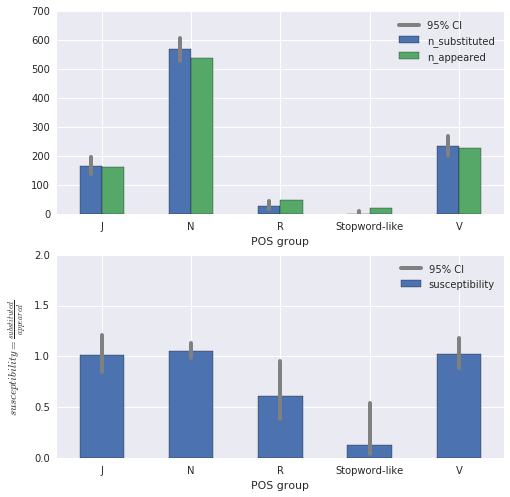

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


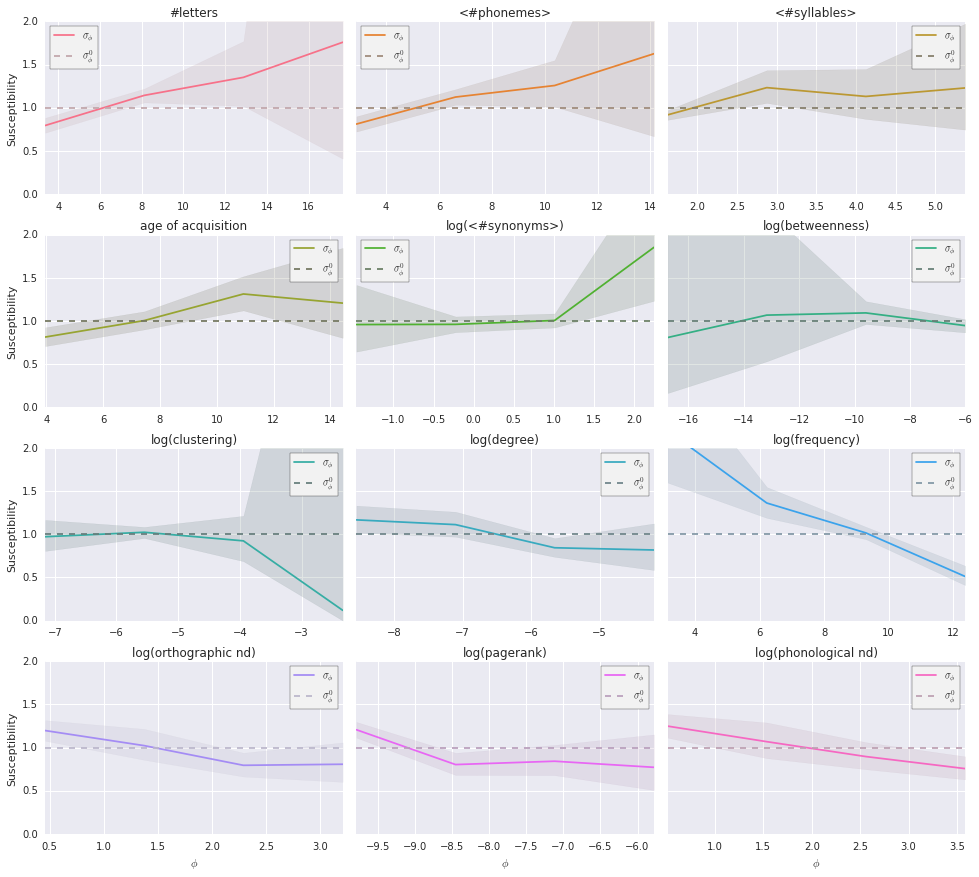

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


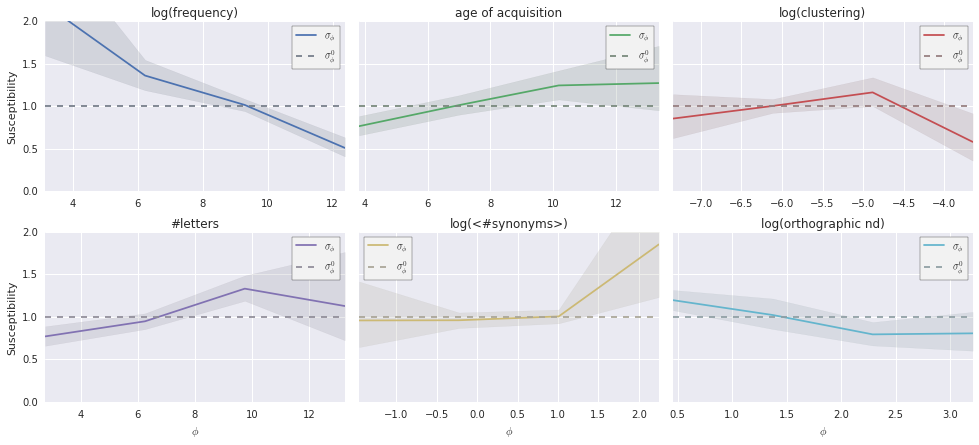

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 2] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


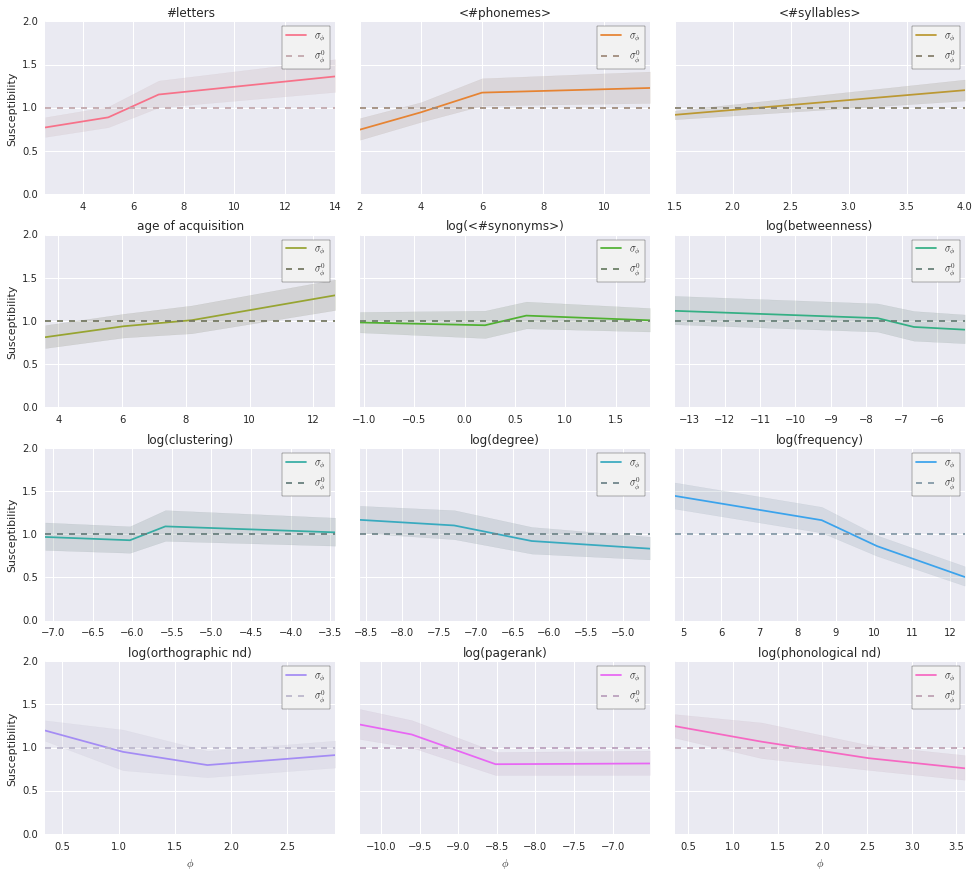

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]


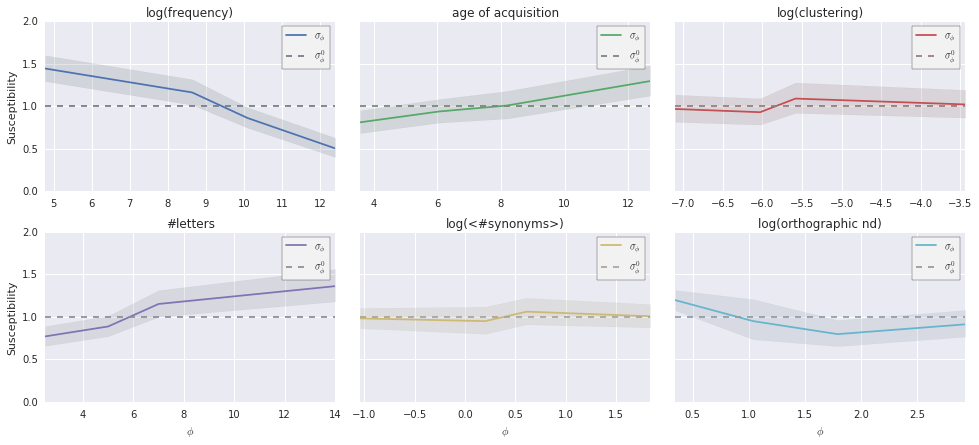

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
     Target NOT different from H_0 (p > 0.001)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
     Target NOT different from H_0 (p > 0.01)



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


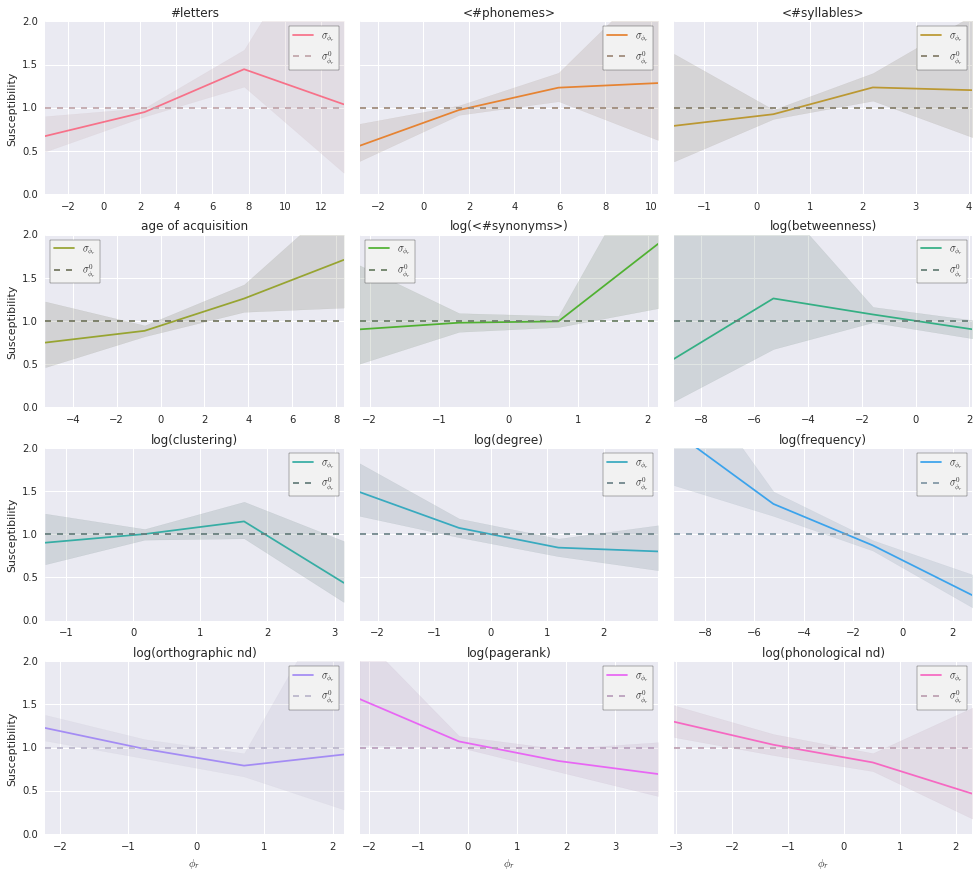

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


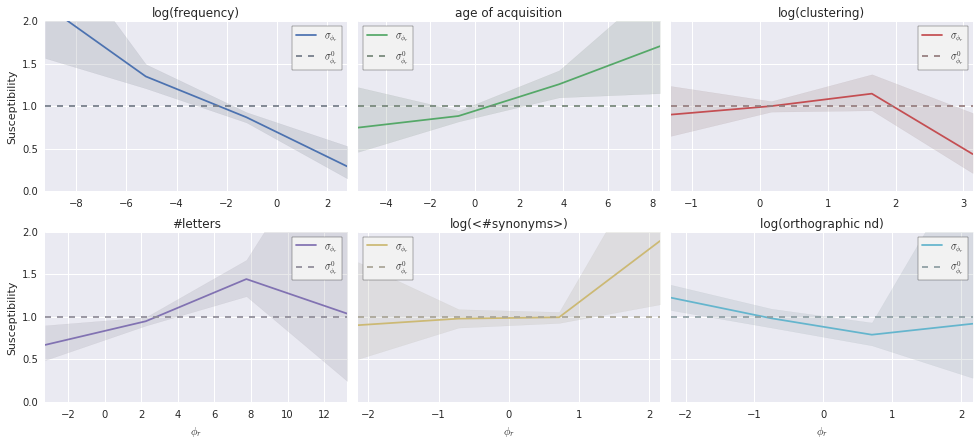

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


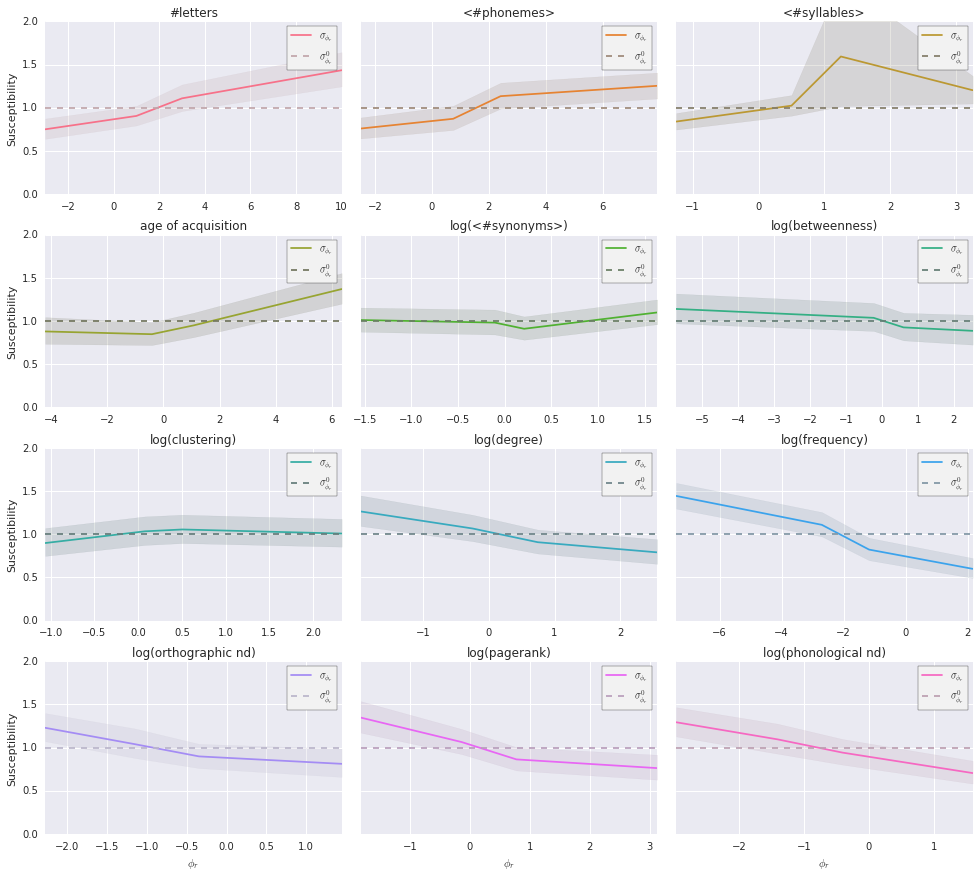

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)


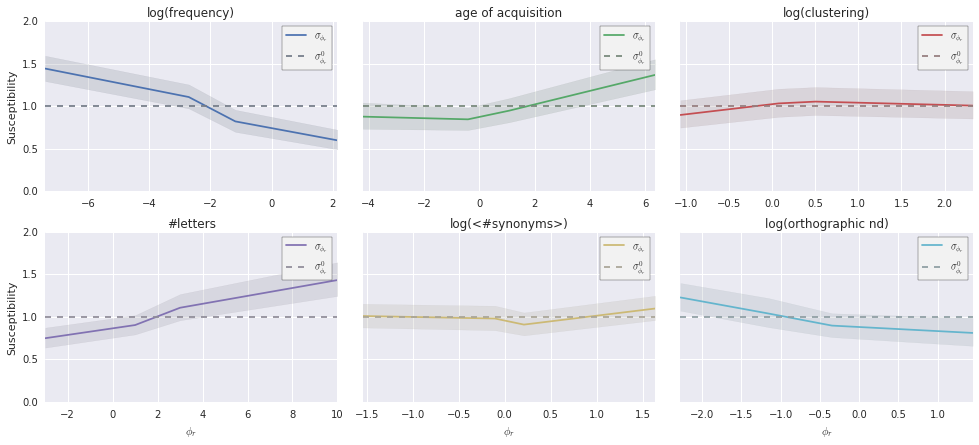

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


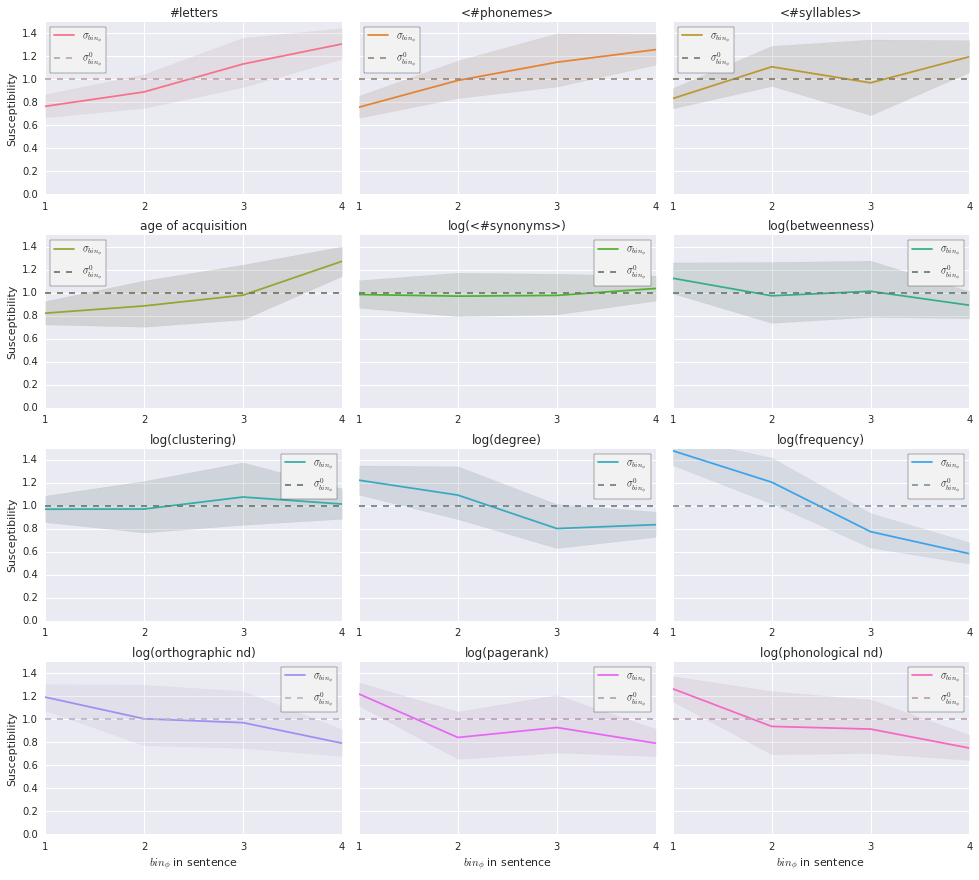

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


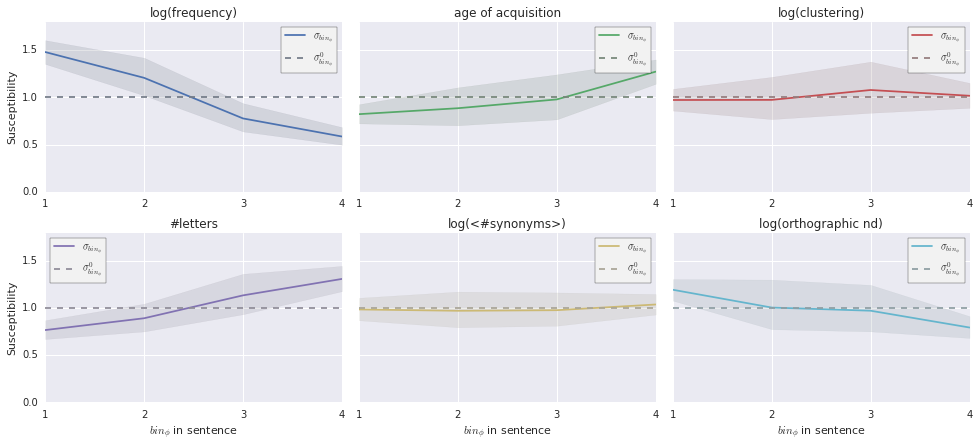

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


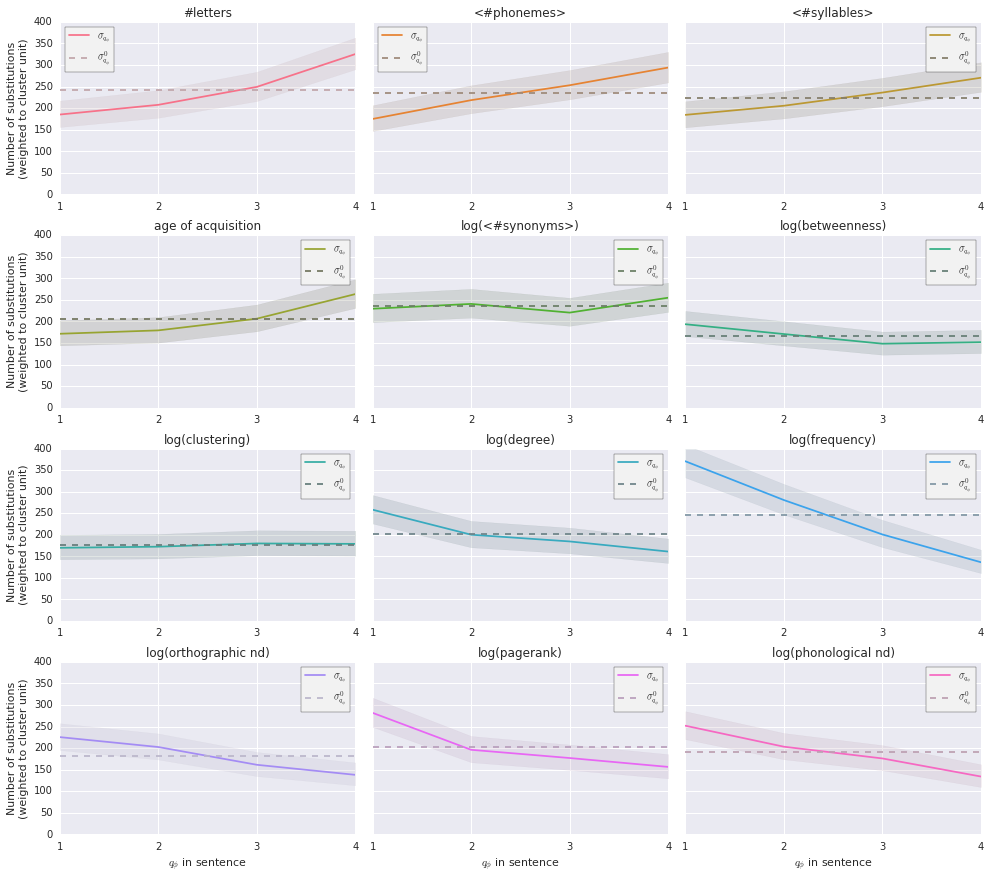

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]


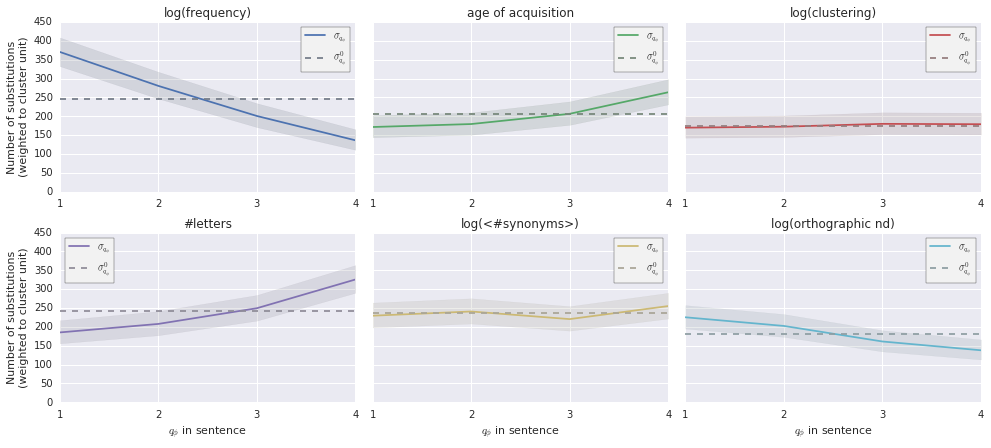

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 69704 word measures (divided into training and prediction sets)



67.22% of words well predicted (non-random at p = 5e-324)
Precision = 0.40
Recall = 0.62

Coefficients:
intercept                                             2.271825
global_frequency                                     -0.590913
global_aoa                                            0.039825
global_letters_count                                 -0.079264
global_orthographic_density                           0.922733
global_frequency * global_aoa                         0.021154
global_frequency * global_letters_count               0.034055
global_frequency * global_orthographic_density        0.031184
global_aoa * global_letters_count                    -0.011280
global_aoa * global_orthographic_density             -0.106824
global_letters_count * global_orthographic_density   -0.019393
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 69704 word measures (divided into training and prediction sets)



48.22% of words well predicted (non-random at p = 3e-11)
Precision = 0.23
Recall = 0.48

Coefficients:
intercept                                                        -0.451594
sentence-rel_frequency                                           -0.159642
sentence-rel_aoa                                                 -0.177678
sentence-rel_letters_count                                        0.182937
sentence-rel_orthographic_density                                 0.319534
sentence-rel_frequency * sentence-rel_aoa                        -0.020913
sentence-rel_frequency * sentence-rel_letters_count               0.033353
sentence-rel_frequency * sentence-rel_orthographic_density        0.074694
sentence-rel_aoa * sentence-rel_letters_count                     0.051140
sentence-rel_aoa * sentence-rel_orthographic_density             -0.002194
sentence-rel_letters_count * sentence-rel_orthographic_density    0.043193
dtype: float64


**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 69704 word measures (divided into training and prediction sets)



61.30% of words well predicted (non-random at p = 5e-324)
Precision = 0.31
Recall = 0.47

Coefficients:
intercept                                                         -0.221255
global_frequency                                                  -0.377010
global_aoa                                                        -0.509409
global_letters_count                                               0.675402
global_orthographic_density                                        2.255932
sentence-rel_frequency                                            -0.070069
sentence-rel_aoa                                                   0.484288
sentence-rel_letters_count                                        -0.299202
sentence-rel_orthographic_density                                 -0.612363
global_frequency * global_aoa                                      0.035859
global_frequency * global_letters_count                            0.027169
global_frequency * global_orthographic_density             

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 69704 word measures (divided into training and prediction sets)



71.78% of words well predicted (non-random at p = 5e-324)
Precision = 0.46
Recall = 0.70

Coefficients:
intercept                                                       0.318887
bins-global_frequency                                          -2.397479
bins-global_aoa                                                 2.382454
bins-global_letters_count                                      -0.598255
bins-global_orthographic_density                               -0.714764
bins-global_frequency * bins-global_aoa                         0.310724
bins-global_frequency * bins-global_letters_count               0.792187
bins-global_frequency * bins-global_orthographic_density       -0.167087
bins-global_aoa * bins-global_letters_count                    -0.925805
bins-global_aoa * bins-global_orthographic_density             -0.413359
bins-global_letters_count * bins-global_orthographic_density    1.014130
dtype: float64


**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 69704 word measures (divided into training and prediction sets)



41.24% of words well predicted (non-random at p = 9e-236)
Precision = 0.27
Recall = 0.80

Coefficients:
intercept                                                                 1.762379
quantiles-global_frequency                                               -3.369541
quantiles-global_aoa                                                      1.153151
quantiles-global_letters_count                                            3.033334
quantiles-global_orthographic_density                                    -2.910920
quantiles-global_frequency * quantiles-global_aoa                         0.128336
quantiles-global_frequency * quantiles-global_letters_count               0.068343
quantiles-global_frequency * quantiles-global_orthographic_density        2.037188
quantiles-global_aoa * quantiles-global_letters_count                    -0.584645
quantiles-global_aoa * quantiles-global_orthographic_density             -0.167977
quantiles-global_letters_count * quantiles-global_orthographic_de

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 69704 word measures (divided into training and prediction sets)



70.94% of words well predicted (non-random at p = 5e-324)
Precision = 0.39
Recall = 0.31

Coefficients:
intercept                                                                   0.829771
bins-sentence-rel_frequency                                                -0.229664
bins-sentence-rel_aoa                                                      -0.324094
bins-sentence-rel_letters_count                                            -0.717275
bins-sentence-rel_orthographic_density                                      0.829771
bins-sentence-rel_frequency * bins-sentence-rel_aoa                        -0.815126
bins-sentence-rel_frequency * bins-sentence-rel_letters_count               0.543942
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density       -0.229664
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                     0.978030
bins-sentence-rel_aoa * bins-sentence-rel_orthographic_density             -0.324094
bins-sentence-rel_letters_count * bins-senten

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 69704 word measures (divided into training and prediction sets)

47.08% of words well predicted (non-random at p = 1e-27)
Precision = 0.27
Recall = 0.67

Coefficients:
intercept                                                                             0.539925
quantiles-sentence-rel_frequency                                                     -0.377175
quantiles-sentence-rel_aoa                                                           -0.449448
quantiles-sentence-rel_letters_count                                                 -0.188161
quantiles-sentence-rel_orthographic_density                                          -0.013969
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                         0.134026
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count              -0.134892
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density        0.154432
quantiles-sentence-rel_aoa * quantiles-sentence-rel_lett

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 69704 word measures (divided into training and prediction sets)

52.46% of words well predicted (non-random at p = 4e-20)
Precision = 0.26
Recall = 0.50

Coefficients:
intercept                                                                -0.517556
in-sentence-bins_frequency                                                0.015331
in-sentence-bins_aoa                                                      0.158221
in-sentence-bins_letters_count                                            0.163248
in-sentence-bins_orthographic_density                                     0.231582
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.175097
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.078361
in-sentence-bins_frequency * in-sentence-bins_orthographic_density       -0.003966
in-sentence-bins_aoa * in-sentence-bins_letters_count                     0.095674
in-sentence-bins_aoa * in-sentence-bins_orthographic_density         

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 808 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.66727035  0.19899375]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.373390  0.567833
aoa            0.752992 -0.276357
letters_count  0.541833  0.775366


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 808 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.62604529  0.21254009]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.498250  0.456063
aoa            0.704708 -0.282450
letters_count  0.505107  0.843936
